### Load libraries

In [1]:
import sys
sys.path.insert(0, '/Users/jarad/Fake Folder/Python Libraries')

from jb_libraries import *
%matplotlib inline

### Script settings

In [24]:
months = 12

date_start = str((dt.datetime.now() - pd.DateOffset(months = months)).date())
now = str(dt.datetime.now().date())

one_year_ago = str((pd.to_datetime(now) - pd.DateOffset(years = 1)).date())

print('Data is between %s and %s, which is the most recent %i months.' % (date_start, now, months))

Data is between 2018-05-09 and 2019-05-09, which is the most recent 12 months.


### Get back in stock notification data

In [3]:
back_main = pd.read_sql(
'''
SELECT
DATE(b.date_subscribed) AS date_subscribed,
DATE(b.date_sent) AS date_sent,
DATE(b.date_bought) AS date_bought,

# a customer can use their ID or their email to set a notification
# i left join on ID
# if the back_in_stock_notification_subscriptions.email is null, there is an ID and a corresponding email from customers.email
# in other words, if back_in_stock_notification_subscriptions.email is null, customers.email will not be null
LOWER(IFNULL(b.email_address, c.customers_email_address)) AS email,

b.customers_id,
b.part_id
FROM bisns_logs b
LEFT JOIN customers c ON b.customers_id = c.customers_id
WHERE DATE(b.date_subscribed) >= ' '''+ date_start +''' '
''', db)

col_fix(back_main)

# change to datetime
for col in ['subscribed','sent','bought']:
        back_main['date %s' % col] = pd.to_datetime(back_main['date %s' % col], errors = 'coerce')
        
# find and remove where emails are null        
n = back_main[back_main['email'].isnull()]
if len(n) < 5:
    back_main.dropna(subset = ['email'], inplace = True)
    back_main.reset_index(drop = True, inplace = True)
else:
    display(n.head())
    raise ValueError('more than %i emails are nulls' % len(n))

# fill in dates where no subscriptions ocurred
dr = pd.date_range(date_start, now)
df = pd.DataFrame(columns = ['date'], data = dr)
df['date'] = pd.to_datetime(df['date'])

back_main = pd.merge(df, back_main, left_on = 'date', right_on = 'date subscribed', how = 'left')

# remove where part id is zeroif the proportion makes up less than 1% of all rows
zeros = back_main[back_main['part id'] == 0]

if len(zeros)/len(back_main) < 0.01: 
    back_main.drop(back_main[back_main['part id'] == 0].index, inplace = True)
    back_main.reset_index(drop = True, inplace = True)
else:
    display(zeros.head())
    raise ValueError('check where part_id = zero')

### Groupby part id check out counts

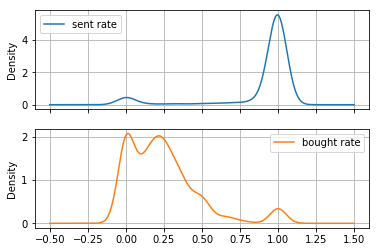

,Lower,Mean,Upper,Stand Dev,Sample Size
sent rate,88.6%,89.9%,91.1%,26.9%,"1,801"
bought rate,23.1%,24.2%,25.3%,23.8%,"1,691"


,bought rate
Count,"1,691"
Mean,24.2%
Std,23.8%
Min,0.0%
25%,5.0%
50%,20.0%
75%,33.3%
Max,100.0%


In [14]:
by_part = back_main.groupby('part id')[['date subscribed','date sent','date bought']].count()
by_part.columns = by_part.columns.str.replace('date ','')

# get these rates
by_part['sent rate'] = by_part['sent']/by_part['subscribed']
by_part['bought rate'] = by_part['bought']/by_part['sent']

# remove where bought > sent
by_part.drop(by_part[by_part['bought'] > by_part['sent']].index, inplace = True)
by_part.reset_index(drop = True, inplace = True)

by_part[['sent rate','bought rate']].plot(subplots = True, kind = 'density', grid = True)
plt.show()

# get confidence intervals
fmt = ['p1'] * 4 + ['n0']
c = jb_conf(by_part[['sent rate','bought rate']]).T.format_(fmt)
display(c)

# describe it
fmt = ['n0'] + ['p1'] * 7
pd.DataFrame(by_part['bought rate'].describe()).T.format_(fmt).T

### Check out z-scores to get probability

In [25]:
import scipy.stats as st

alpha = 0.05
# one sided, scipy.stats.norm.ppf is not by default two-sided
probit = st.norm.ppf((1 - alpha))

by_part_z = (by_part - np.mean(by_part))/np.std(by_part)

m = by_part['bought rate'].mean()
s = by_part['bought rate'].std()

val = m + (probit * s)

v1 = np.sum(by_part['bought rate'] <= val)
v2 = np.sum(by_part['bought rate'] > val)

# this is P(X <= x) = 0.95
# -> P(Z <= (x-mu)/s) = 0.95
# -> x = (0.95*s) + mu
print('There is a {:,.0f}% chance that any "bought rate" will be below {:,.1f}%.'.format((1-alpha) * 100, val * 100))

There is a 95% chance that any "bought rate" will be below 63.3%.


In [18]:
print('done')

done
